In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping


2025-06-18 17:27:37.933897: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750267657.957259     164 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750267657.964340     164 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
data_dir = "/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train"

In [20]:
import os
import cv2

img_size = 224  # Define image size here

X = []
y = []
skipped = 0

labels = sorted(os.listdir(data_dir))
print("Labels:", labels)

for idx, label in enumerate(labels):
    folder = os.path.join(data_dir, label)
    for img_file in os.listdir(folder)[:200]:  # limit to 200 per class
        img_path = os.path.join(folder, img_file)
        img = cv2.imread(img_path)
        if img is None:
            skipped += 1
            continue
        img = cv2.resize(img, (img_size, img_size))
        X.append(img)
        y.append(idx)

print(f"Total images loaded: {len(X)}")
print(f"Total skipped images: {skipped}")


Labels: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']
Total images loaded: 5800
Total skipped images: 0


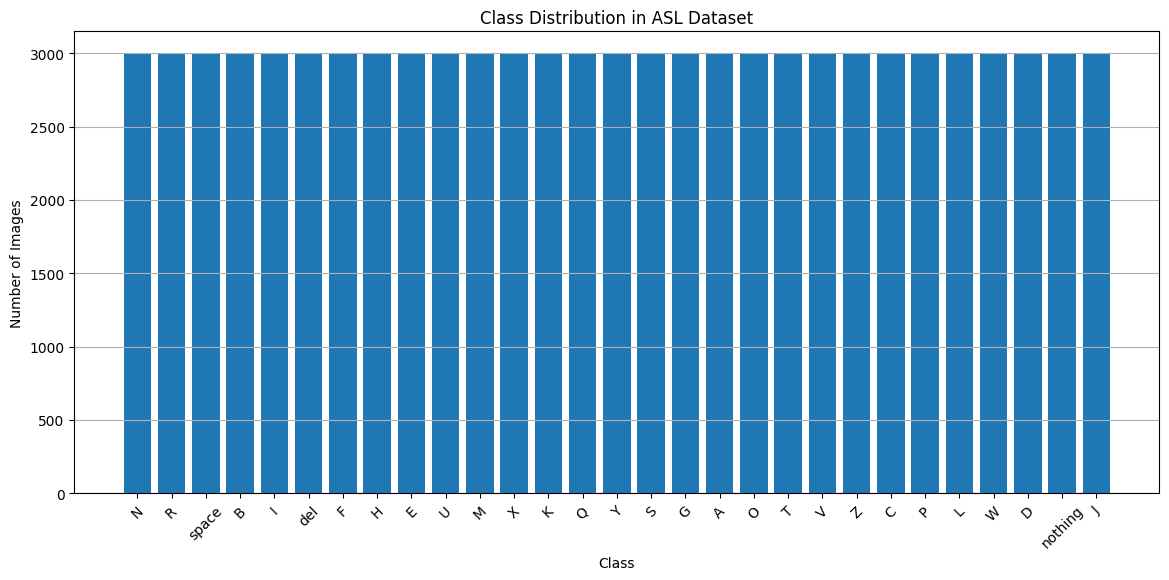

In [21]:
import matplotlib.pyplot as plt

classes = os.listdir(data_dir)
class_counts = [len(os.listdir(os.path.join(data_dir, c))) for c in classes]

plt.figure(figsize=(14, 6))
plt.bar(classes, class_counts)
plt.xticks(rotation=45)
plt.title('Class Distribution in ASL Dataset')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.grid(axis='y')
plt.show()


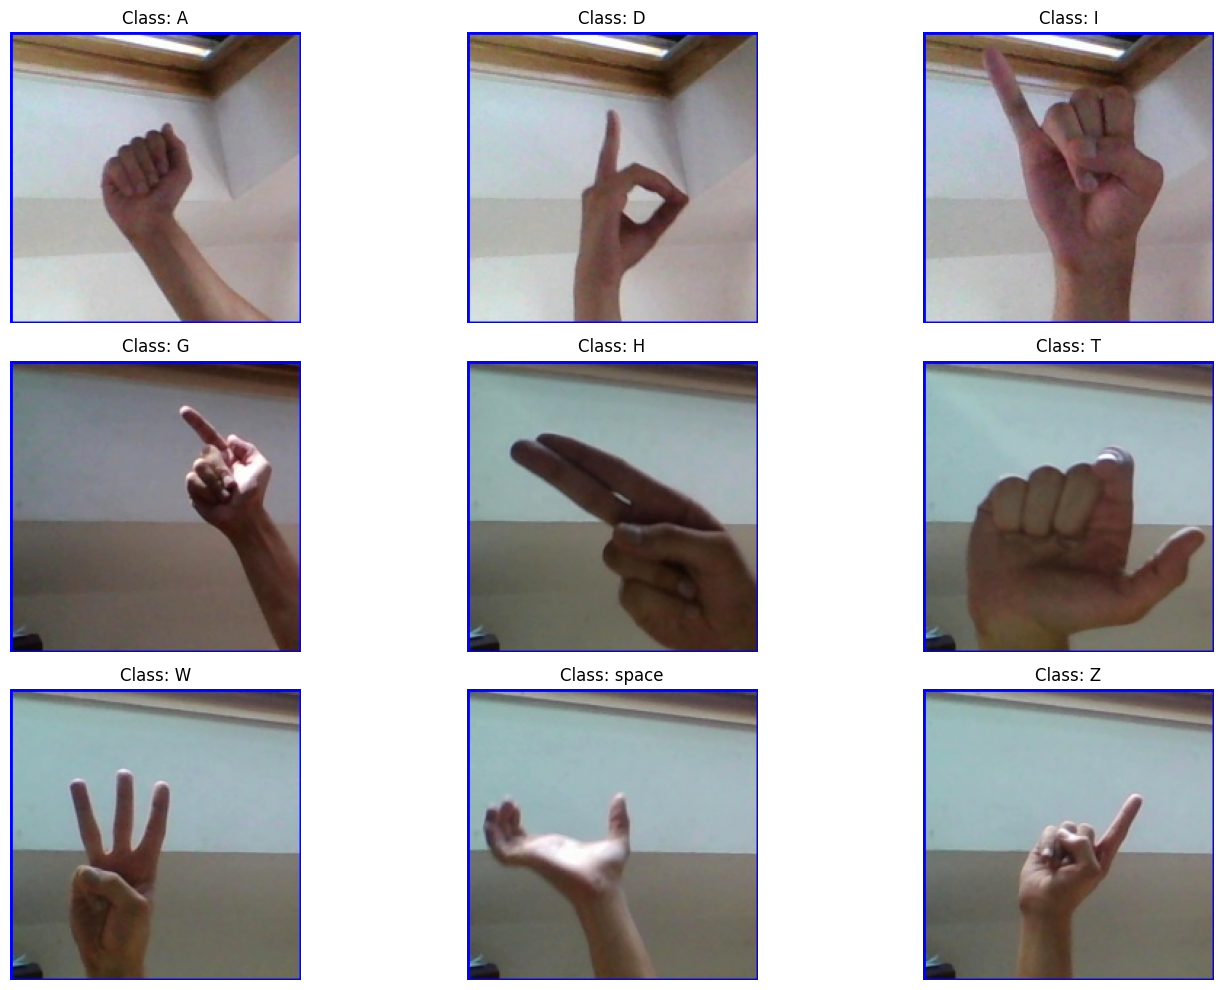

In [22]:
import cv2
import random

plt.figure(figsize=(15, 10))

for i, c in enumerate(random.sample(classes, 9)):
    img_path = os.path.join(data_dir, c, os.listdir(os.path.join(data_dir, c))[0])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(f"Class: {c}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = 224  # to match MobileNetV2 pretrained weights

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_gen = train_datagen.flow_from_directory(
    "/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train",
    target_size=(img_size, img_size),
    batch_size=64,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_gen = train_datagen.flow_from_directory(
    "/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train",
    target_size=(img_size, img_size),
    batch_size=64,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)


Found 69600 images belonging to 29 classes.
Found 17400 images belonging to 29 classes.


In [6]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam

base_model = MobileNetV2(
    input_shape=(img_size, img_size, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False


inputs = Input(shape=(img_size, img_size, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(train_gen.num_classes, activation='softmax')(x)

model = Model(inputs, outputs)

model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


I0000 00:00:1750267687.942751     164 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 29)                  │           7,453 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,593,373 (9.89 MB)

 Trainable params: 335,389 (1.28 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', save_best_only=True)
]

In [8]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15


I0000 00:00:1750267698.847070     229 service.cc:148] XLA service 0x7a568c211db0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750267698.847128     229 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1750267699.666003     229 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/1088 ━━━━━━━━━━━━━━━━━━━━ 3:41:59 12s/step - accuracy: 0.0156 - loss: 4.1664

I0000 00:00:1750267703.733187     229 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1088/1088 ━━━━━━━━━━━━━━━━━━━━ 1314s 1s/step - accuracy: 0.4085 - loss: 2.1751 - val_accuracy: 0.7470 - val_loss: 0.9782
Epoch 2/15
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 1050s 965ms/step - accuracy: 0.8369 - loss: 0.5787 - val_accuracy: 0.7900 - val_loss: 0.7370
Epoch 3/15
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 1048s 963ms/step - accuracy: 0.8980 - loss: 0.3685 - val_accuracy: 0.8051 - val_loss: 0.6504
Epoch 4/15
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 1066s 980ms/step - accuracy: 0.9226 - loss: 0.2701 - val_accuracy: 0.8194 - val_loss: 0.5920
Epoch 5/15
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 1056s 970ms/step - accuracy: 0.9383 - loss: 0.2147 - val_accuracy: 0.8240 - val_loss: 0.5699
Epoch 6/15
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 1030s 947ms/step - accuracy: 0.9482 - loss: 0.1798 - val_accuracy: 0.8253 - val_loss: 0.5609
Epoch 7/15
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 1027s 944ms/step - accuracy: 0.9548 - loss: 0.1546 - val_accuracy: 0.8323 - val_loss: 0.5460
Epoch 8/15
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 1032s 948ms/step - accuracy

In [10]:
# Save the model
model.save("asl_mobilenet_model.h5")

# Load later like this
# from tensorflow.keras.models import load_model
# model = load_model("asl_mobilenet_model.h5")



In [13]:
!zip asl_model.zip asl_mobilenet_model.h5


  adding: asl_mobilenet_model.h5 (deflated 10%)


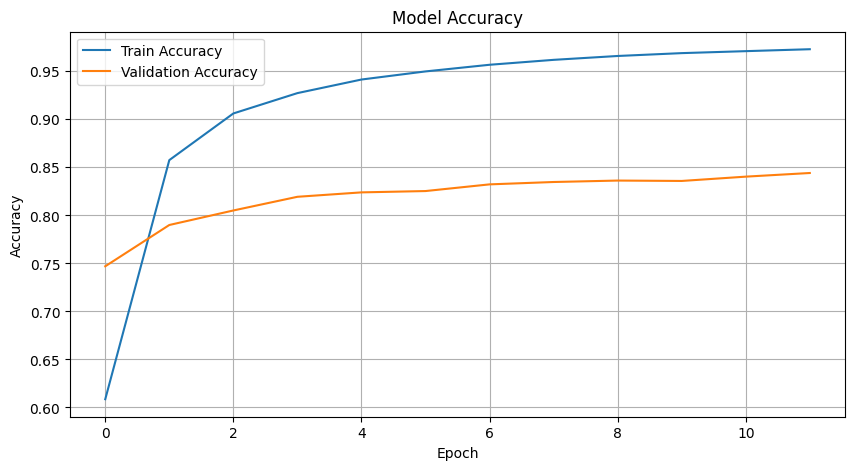

In [11]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()



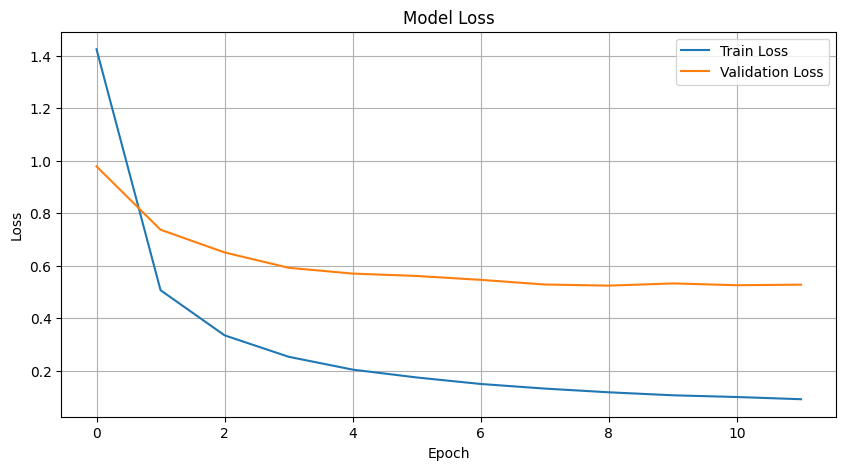

In [12]:
# Loss plot
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


272/272 ━━━━━━━━━━━━━━━━━━━━ 197s 724ms/step


<Figure size 3000x1800 with 0 Axes>

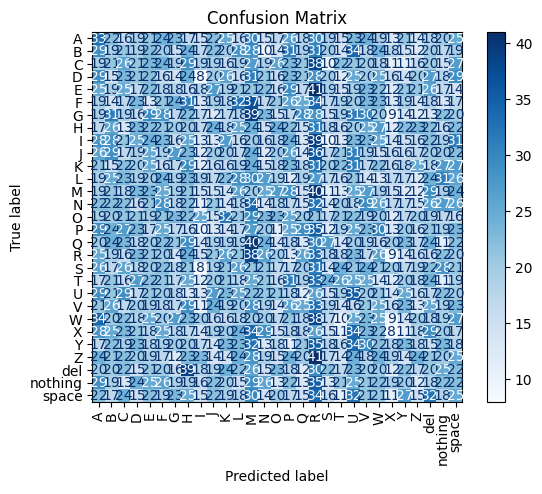

In [19]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict the validation data
Y_pred = model.predict(val_gen)
y_pred = np.argmax(Y_pred, axis=1)

# True labels
y_true = val_gen.classes

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(val_gen.class_indices.keys()))

# Plot
plt.figure(figsize=(30, 18))
disp.plot(cmap='Blues', xticks_rotation=90)
plt.title("Confusion Matrix")
plt.show()


In [15]:
import os
import cv2
import numpy as np

test_dir = '/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test'
img_size = 224  # should match your model

test_images = []
test_labels = []
label_names = sorted(os.listdir(test_dir))  # should match your training labels

for label in label_names:
    img_path = os.path.join(test_dir, label)
    img = cv2.imread(img_path)
    img = cv2.resize(img, (img_size, img_size))
    img = img.astype('float32') / 255.0
    test_images.append(img)
    test_labels.append(label)

test_images = np.array(test_images)


In [16]:
preds = model.predict(test_images)
predicted_indices = np.argmax(preds, axis=1)

# Map indices back to class names
idx_to_class = {v: k for k, v in train_gen.class_indices.items()}
predicted_labels = [idx_to_class[i] for i in predicted_indices]


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


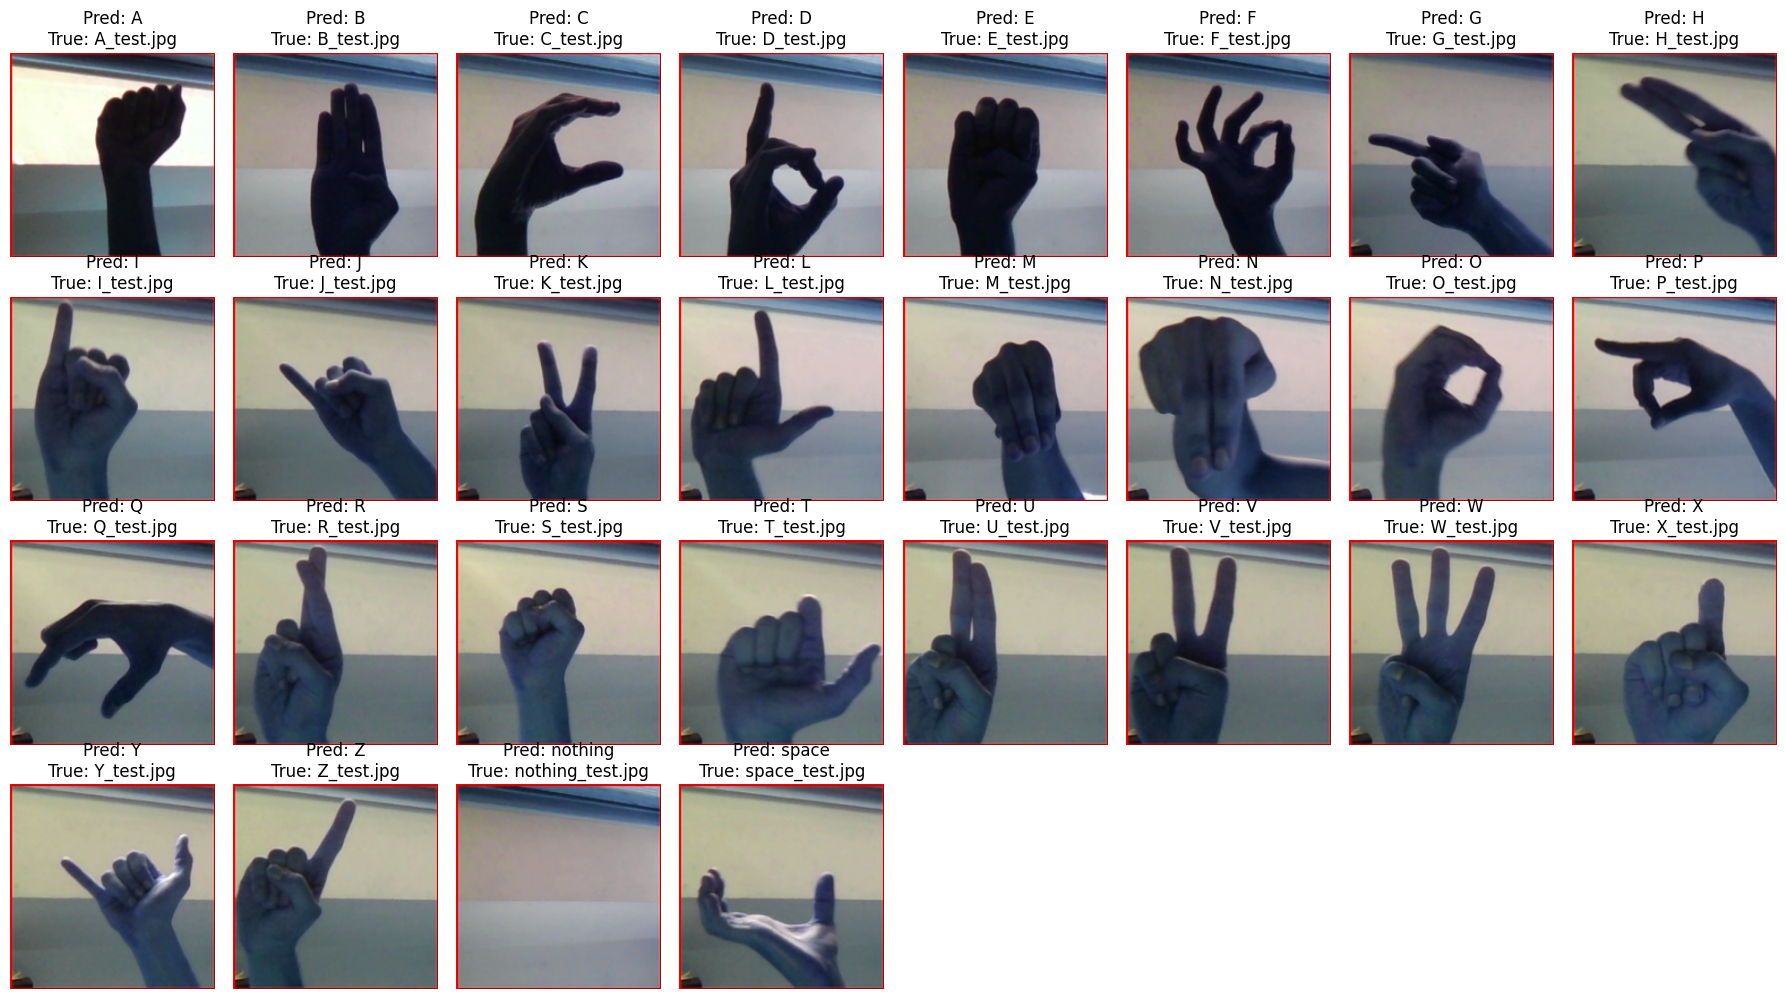

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 10))

for i in range(len(test_images)):
    plt.subplot(4, 8, i + 1)
    plt.imshow(test_images[i])
    plt.title(f"Pred: {predicted_labels[i]}\nTrue: {test_labels[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()
